# Plot the lab result distribution per lab test

Database discription
1. age
2. LOS in ICU
3. Crystalloid volumne
4. ICU types
5. ADmission types
6. Cardiac surgery proportion

other parts of the resluts are just drafts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde
from scipy import integrate
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
import scipy.stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

## load data

In [2]:
data_mimic = pd.read_csv('../datasets/processed data/MIMIC-data-update202012.csv')
data_aumc = pd.read_csv('../datasets/processed data/AUMC-data-update202012.csv')
data_eicu = pd.read_csv('../datasets/processed data/eCRD-data-update202012.csv')
data_plagh = pd.read_csv('../datasets/processed data/PLAGH-data-update202012.csv')
data_HJ23 = pd.read_csv('../datasets/processed data/HJ23-data-update202012.csv')

In [3]:
data_plagh['lactate_max']=np.nan

In [4]:
#selected lab tests
lab_names=['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min']

In [5]:
database_all=[data_mimic,data_eicu,data_plagh,data_aumc,data_HJ23]

In [6]:
lab_ranges = {'ALBUMIN':[3.5, 5.5], 
              'BICARBONATE': [22,32],
              'CALCIUM': [8.4,10.3],
              'CREATININE': [0.4,1.1],
              'GLUCOSE':[70.0, 100.0],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145],
              'IONIZEDCALCIUM': [1.1, 1.35],
              'WBC': [3.5, 10.5]
             }

## database description

### age

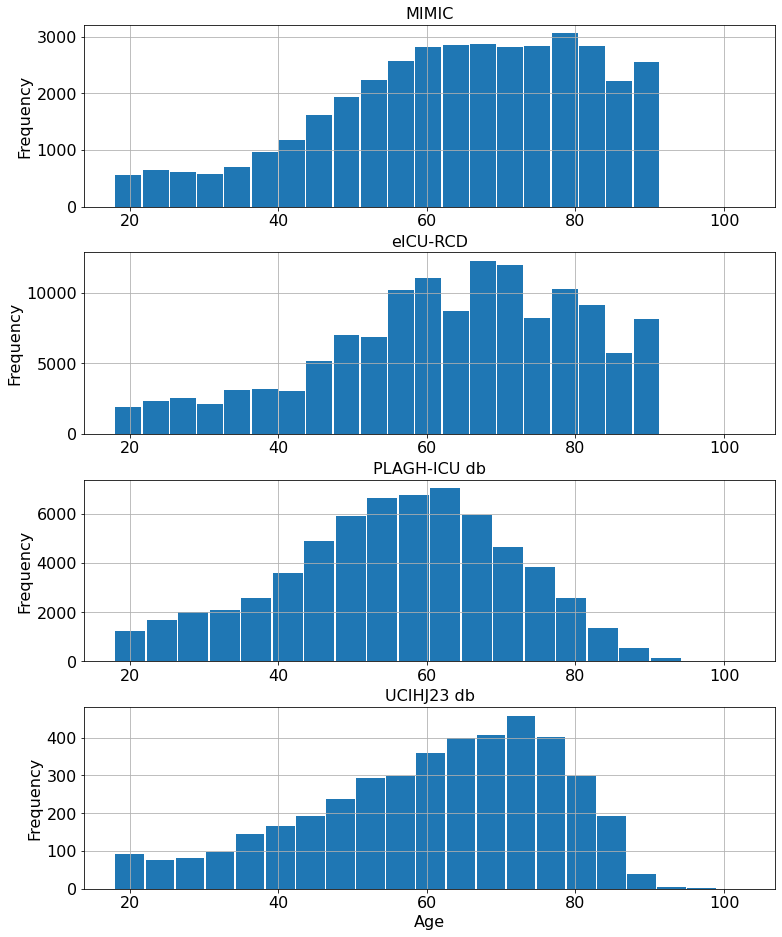

In [28]:
#mimic
plt.figure(figsize=(12,15))
ax1=plt.subplot(411)
data_mimic['age'].hist(bins=20,rwidth=0.95)
plt.ylabel('Frequency')
plt.title('MIMIC',fontsize=16)
#e-ICU
ax2=plt.subplot(412, sharex = ax1)
data_eicu['age'].hist(bins=20,rwidth=0.95)
plt.ylabel('Frequency')
plt.title('eICU-RCD',fontsize=16)
#PLAGH
ax3=plt.subplot(413, sharex = ax1)
data_plagh['age'].hist(bins=20,rwidth=0.95)
plt.ylabel('Frequency')
plt.title('PLAGH-ICU db',fontsize=16)
#HJ23
ax4=plt.subplot(414, sharex = ax1)
data_HJ23['age'].hist(bins=20,rwidth=0.95)
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('UCIHJ23 db',fontsize=16)


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,hspace=0.25)
plt.savefig('../figures/database description/age_distribution.png', dpi=300)

In [14]:
age_group_df=pd.DataFrame()
age_group_df['MIMIC']=data_mimic['age_group'].value_counts()/np.sum(data_mimic['age_group'].notnull())
age_group_df['e-ICU']=data_eicu['age_group'].value_counts()/np.sum(data_eicu['age_group'].notnull())
age_group_df['PLAGH']=data_plagh['age_group'].value_counts()/np.sum(data_plagh['age_group'].notnull())
age_group_df['AUMC']=data_aumc['age_group'].value_counts()/np.sum(data_aumc['age_group'].notnull())
age_group_df['HJ23']=data_HJ23['age_group'].value_counts()/np.sum(data_HJ23['age_group'].notnull())
age_group_df

,MIMIC,e-ICU,PLAGH,AUMC,HJ23
"(79, 300]",0.225090,0.190535,0.054727,0.101505,0.106654
"(69, 79]",0.205910,0.210716,0.149429,0.263129,0.246107
"(59, 69]",0.201856,0.220536,0.243029,0.262036,0.232657
"(49, 59]",0.166823,0.177467,0.240431,0.169325,0.172015
"(39, 49]",0.102188,0.091906,0.163489,0.094550,0.116564
"(17, 39]",0.098134,0.108839,0.148894,0.109455,0.126003


In [15]:
age_group_df.sort_index(inplace=True)

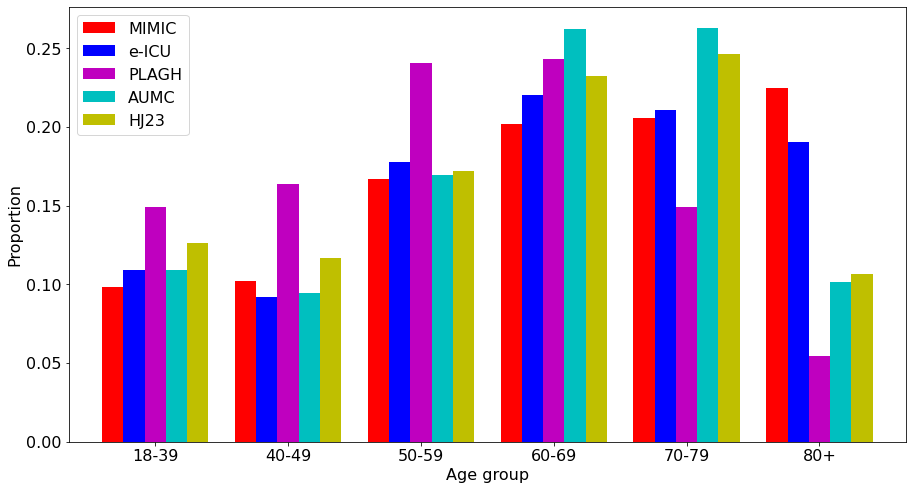

In [16]:
x=['(17, 39]','(39, 49]','(49, 59]', '(59, 69]','(69, 79]','(79, 300]']
# age_df

# plt.figure(figsize=(15,15))
# ax1=plt.subplot(511)
# plt.bar(x,data_mimic['age_group'].value_counts()[x])
# plt.ylabel('Count')
# plt.title('MIMIC')
# ax2=plt.subplot(512)
# plt.bar(x,data_eicu['age_group'].value_counts()[x])
# plt.ylabel('Count')
# plt.title('e-ICU')
# ax3=plt.subplot(513)
# plt.bar(x,data_plagh['age_group'].value_counts()[x])
# plt.ylabel('Count')
# plt.title('PLAGH')
# ax4=plt.subplot(514)
# plt.bar(x,data_aumc['age_group'].value_counts()[x])
# plt.ylabel('Count')
# plt.title('AUMC')
# ax5=plt.subplot(515, sharex = ax1)
# plt.bar(x,data_HJ23['age_group'].value_counts()[x])
# plt.ylabel('Count')
# plt.title('HJ23')

ax=age_group_df.plot.bar(fontsize=16,figsize=(15,8),width = 0.8,color=['r','b','m','c','y'])
#plt.xticks(['18-39','40-49','50-59','60-69','70-79','80+'],rotation=0)
ax.set_xticklabels(['18-39','40-49','50-59','60-69','70-79','80+'],rotation=0)
ax.legend(fontsize=16)
ax.set_xlabel('Age group',fontsize=16)
ax.set_ylabel('Proportion',fontsize=16)
plt.savefig('../figures/database description/age_group_proportion.png', dpi=300)

### ICU LOS

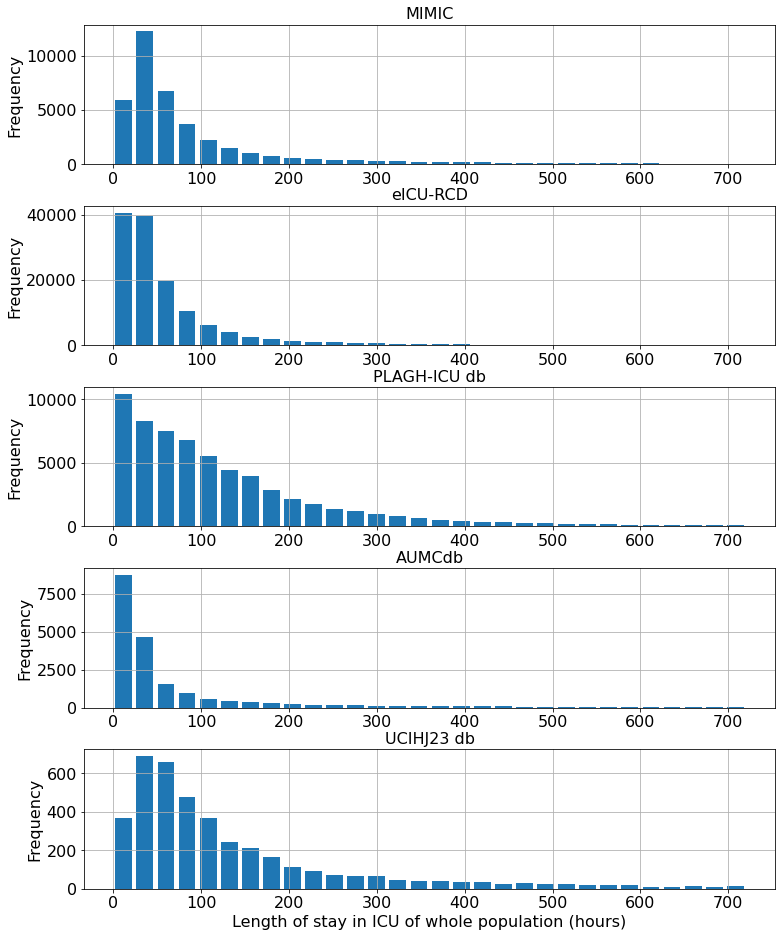

In [29]:
#all patients
plt.figure(figsize=(12,15))
ax1=plt.subplot(511)
data_mimic['icu_los_hours'].hist(bins=30,range=(0,720),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('MIMIC',fontsize=16)
ax2=plt.subplot(512, sharex = ax1)
data_eicu['icu_los_hours'].hist(bins=30,range=(0,720),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('eICU-RCD',fontsize=16)
ax3=plt.subplot(513, sharex = ax1)
data_plagh['icu_los_hours'].hist(bins=30,range=(0,720),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('PLAGH-ICU db',fontsize=16)
ax3=plt.subplot(514, sharex = ax1)
data_aumc['icu_los_hours'].hist(bins=30,range=(0,720),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('AUMCdb',fontsize=16)
ax5=plt.subplot(515, sharex = ax1)
data_HJ23['icu_los_hours'].hist(bins=30,range=(0,720),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('UCIHJ23 db',fontsize=16)
plt.xlabel('Length of stay in ICU of whole population (hours)',fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,hspace=0.3)
plt.savefig('../figures/database description/LOS in ICU distribution.png', dpi=300)

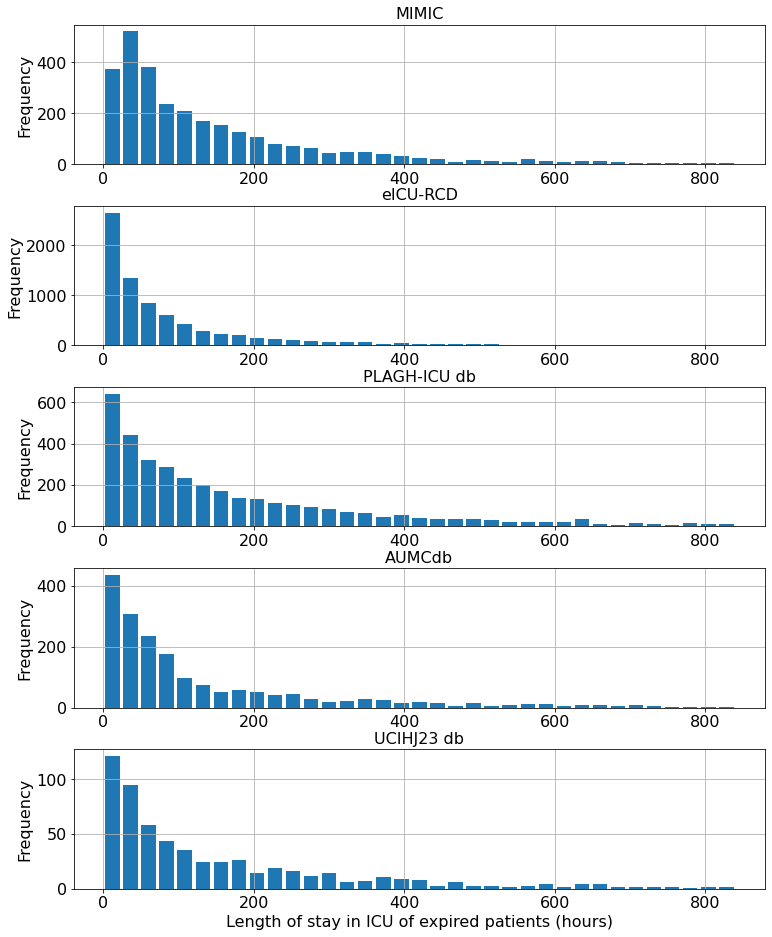

In [30]:
#expired patients
plt.figure(figsize=(12,15))
ax1=plt.subplot(511)
data_mimic.loc[data_mimic['icu_expire_flag']==1,:]['icu_los_hours'].hist(bins=35,range=(0,840),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('MIMIC',fontsize=16)
ax2=plt.subplot(512, sharex = ax1)
data_eicu.loc[data_eicu['icu_expire_flag']==1,:]['icu_los_hours'].hist(bins=35,range=(0,840),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('eICU-RCD',fontsize=16)
ax3=plt.subplot(513, sharex = ax1)
data_plagh.loc[data_plagh['icu_expire_flag']==1,:]['icu_los_hours'].hist(bins=35,range=(0,840),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('PLAGH-ICU db',fontsize=16)
ax3=plt.subplot(514, sharex = ax1)
data_aumc.loc[data_aumc['icu_expire_flag']==1,:]['icu_los_hours'].hist(bins=35,range=(0,840),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('AUMCdb',fontsize=16)
ax5=plt.subplot(515, sharex = ax1)
data_HJ23.loc[data_HJ23['icu_expire_flag']==1,:]['icu_los_hours'].hist(bins=35,range=(0,840),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('UCIHJ23 db',fontsize=16)
plt.xlabel('Length of stay in ICU of expired patients (hours)',fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,hspace=0.3)
plt.savefig('../figures/database description/Expired patients LOS in ICU distribution.png', dpi=300)

### hospital LOS

dropped

plt.figure(figsize=(12,15))
ax1=plt.subplot(411)
data_mimic['hospital_los_hours'].hist(bins=60,range=(0,1440),rwidth=0.8)
plt.ylabel('Count-MIMIC',fontsize=16)
ax2=plt.subplot(412, sharex = ax1)
data_eicu['hospital_los_hours'].hist(bins=60,range=(0,1440),rwidth=0.8)
plt.ylabel('Count-e-ICU',fontsize=16)
ax3=plt.subplot(413, sharex = ax1)
data_plagh['hospital_los_hours'].hist(bins=60,range=(0,1440),rwidth=0.8)
plt.ylabel('Count-PLAGH',fontsize=16)
ax3=plt.subplot(414, sharex = ax1)
# data_aumc['hospital_los_hours'].hist(bins=20,range=(0,480),rwidth=0.8)
# plt.ylabel('Count-AUMC',fontsize=16)
# ax5=plt.subplot(515, sharex = ax1)
data_HJ23['hospital_los_hours'].hist(bins=60,range=(0,1440),rwidth=0.8)
plt.ylabel('Count-HJ23',fontsize=16)
plt.xlabel('LOS in hospital (hours)',fontsize=16)
plt.savefig('../figures/database description/LOS in hospital distribution.png', dpi=300)

## Crystalloid Volume

In [25]:
reliable_l=pd.read_csv('../datasets/ReliableHospitalICUYearFilter.csv')
reliable_l['reliable']=1
reliable_l.drop(['HospitalID','UnitAdmitYear'],axis=1,inplace=True)
reliable_l.drop_duplicates(inplace=True)
data_eicu=pd.merge(data_eicu,reliable_l,left_on='wardid',right_on='ICUID',how='left')

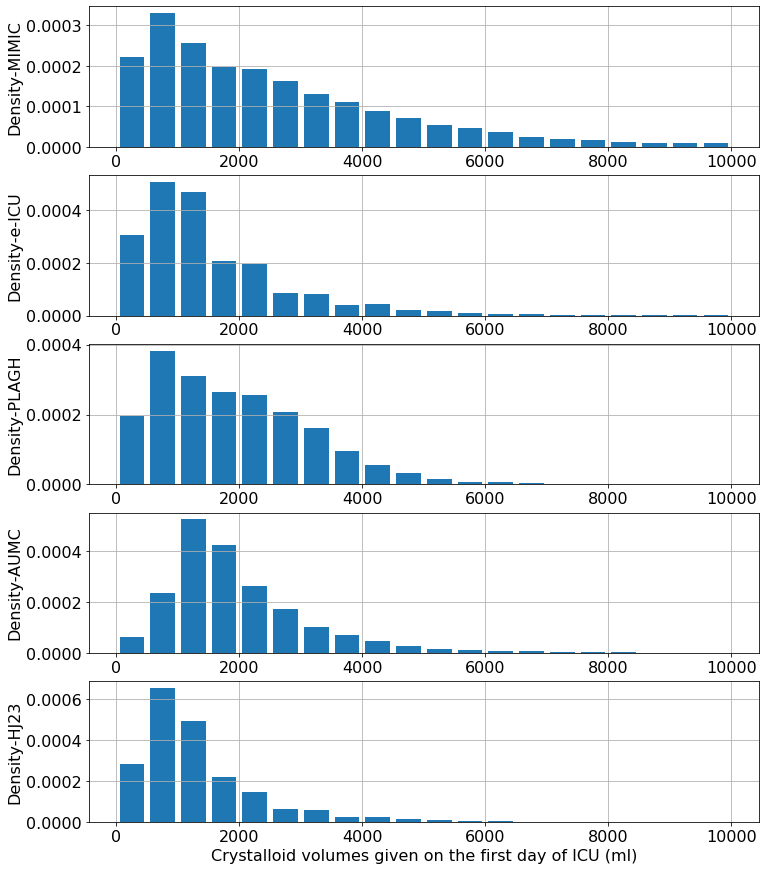

In [26]:
# a draft that has been dropped
plt.figure(figsize=(12,15))
ax1=plt.subplot(511)
data_mimic['crystalloid_v'].hist(bins=20,density =True,range=(0,10000), rwidth=0.8)
plt.ylabel('Density-MIMIC',fontsize=16)
ax2=plt.subplot(512, sharex = ax1)
data_eicu.loc[data_eicu['reliable']==1,'crystalloid_v'].hist(bins=20,density =True,range=(0,10000),rwidth=0.8)
plt.ylabel('Density-e-ICU',fontsize=16)
ax3=plt.subplot(513, sharex = ax1)
data_plagh['crystalloid_v'].hist(bins=20,density =True,range=(0,10000),rwidth=0.8)
plt.ylabel('Density-PLAGH',fontsize=16)
ax4=plt.subplot(514, sharex = ax1)
data_aumc['crystalloid_v'].hist(bins=20,density =True,range=(0,10000),rwidth=0.8)
plt.ylabel('Density-AUMC',fontsize=16)
ax5=plt.subplot(515, sharex = ax1)
data_HJ23['crystalloid_v'].hist(bins=20,density =True,range=(0,10000),rwidth=0.8)
plt.ylabel('Density-HJ23',fontsize=16)
plt.xlabel('Crystalloid volumes given on the first day of ICU (ml)',fontsize=16)
plt.savefig('../figures/database description/Crystalloid distribution_density.png', dpi=300)

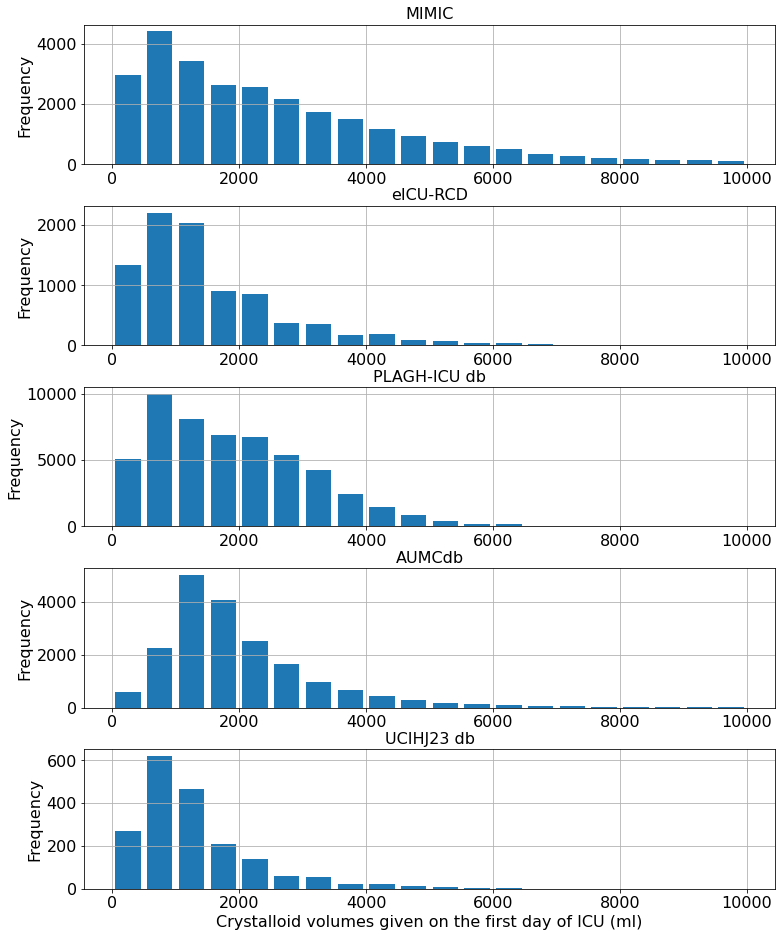

In [31]:
plt.figure(figsize=(12,15))
ax1=plt.subplot(511)
data_mimic['crystalloid_v'].hist(bins=20,range=(0,10000), rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('MIMIC',fontsize=16)
ax2=plt.subplot(512, sharex = ax1)
data_eicu.loc[data_eicu['reliable']==1,'crystalloid_v'].hist(bins=20,range=(0,10000),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('eICU-RCD',fontsize=16)
ax3=plt.subplot(513, sharex = ax1)
data_plagh['crystalloid_v'].hist(bins=20,range=(0,10000),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('PLAGH-ICU db',fontsize=16)
ax4=plt.subplot(514, sharex = ax1)
data_aumc['crystalloid_v'].hist(bins=20,range=(0,10000),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('AUMCdb',fontsize=16)
ax5=plt.subplot(515, sharex = ax1)
data_HJ23['crystalloid_v'].hist(bins=20,range=(0,10000),rwidth=0.8)
plt.ylabel('Frequency',fontsize=16)
plt.title('UCIHJ23 db',fontsize=16)
plt.xlabel('Crystalloid volumes given on the first day of ICU (ml)',fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1,hspace=0.3)
plt.savefig('../figures/database description/Crystalloid distribution_count.png', dpi=300)

### ICU type

MIMIC, e-ICU, PLAGH,HJ23

In [16]:
print(data_mimic['unittype'].unique())
print(data_eicu['unittype'].unique())
print(data_plagh['unittype'].unique())
print(data_aumc['unittype'].unique())
print(data_HJ23['unittype'].unique())

['MICU' 'SICU' 'CCU' 'CSRU' 'TSICU']
['Med-Surg ICU' 'MICU' 'NICU' 'CCU-CTICU' 'CTICU' 'SICU' 'CCU' 'CSICU']
['TICU' 'CCU' 'SICU' 'EICU' 'RICU' 'NSICU' 'CSICU' 'NICU' 'KICU']
['SICU' 'MICU' 'SICU&MICU']
['SICU' 'MICU']


In [17]:
data_mimic['unittype'].value_counts()

MICU     13600
CSRU      7600
SICU      6356
CCU       5694
TSICU     5228
Name: unittype, dtype: int64

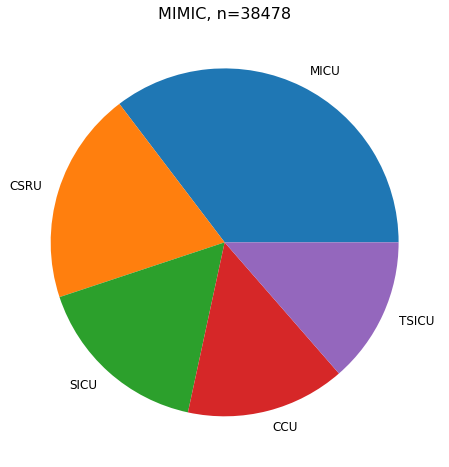

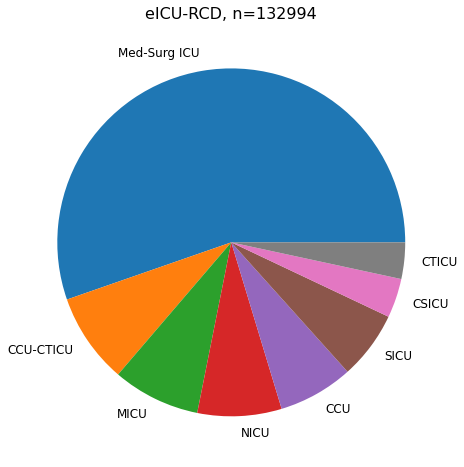

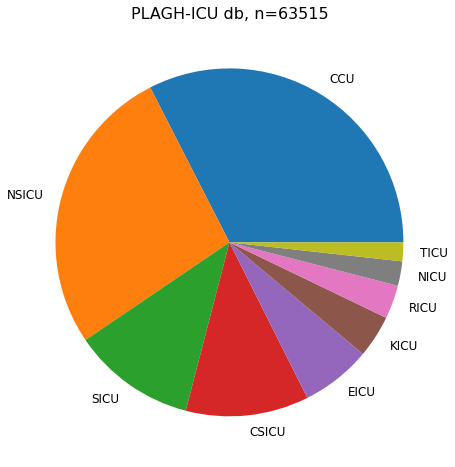

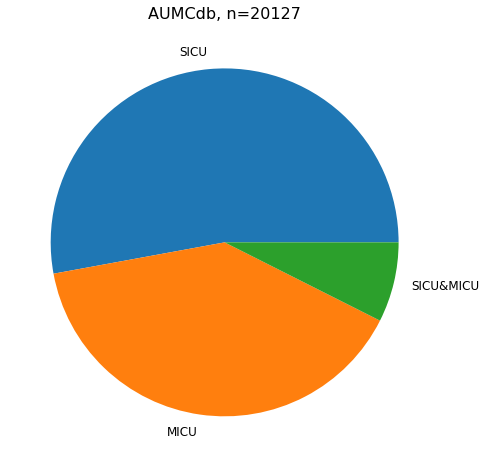

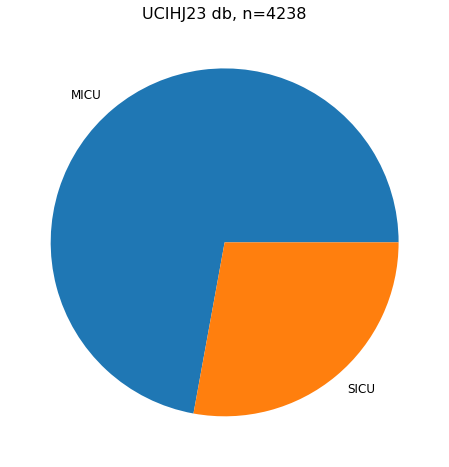

In [32]:
mpl.rcParams['font.size'] = 12
plt.figure(figsize=(8,8))
plt.pie(data_mimic['unittype'].value_counts(),
       labels=data_mimic['unittype'].value_counts().keys(),
       #colors=[icutype_color[x] for x in data_mimic['unittype'].value_counts().keys().values],
       #autopct = '%3.2f%%',
       startangle =0)
number=np.sum(data_mimic['unittype'].notnull())
plt.ylabel('')
plt.title('MIMIC, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/mimic icu types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_eicu['unittype'].value_counts(),
       labels=data_eicu['unittype'].value_counts().keys(),
       #colors=[icutype_color[x] for x in data_eicu['unittype'].value_counts().keys().values],
       #autopct = '%3.2f%%',
       startangle =0)
number=np.sum(data_eicu['unittype'].notnull())
plt.ylabel('')
plt.title('eICU-RCD, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/eicu icu types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_plagh['unittype'].value_counts(),
       labels=data_plagh['unittype'].value_counts().keys(),
       #colors=[icutype_color[x] for x in data_plagh['unittype'].value_counts().keys().values],
       #autopct = '%3.2f%%',
       startangle =0)
number=np.sum(data_plagh['unittype'].notnull())
plt.ylabel('')
plt.title('PLAGH-ICU db, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/plagh icu types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_aumc['unittype'].value_counts(),
       labels=data_aumc['unittype'].value_counts().keys(),
       #colors=[icutype_color[x] for x in data_aumc['unittype'].value_counts().keys().values],
       #autopct = '%3.2f%%',
       startangle =0)
number=np.sum(data_aumc['unittype'].notnull())
plt.ylabel('')
plt.title('AUMCdb, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/aumc icu types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_HJ23['unittype'].value_counts(),
       labels=data_HJ23['unittype'].value_counts().keys(),
       #colors=[icutype_color[x] for x in data_HJ23['unittype'].value_counts().keys().values],
       #autopct = '%3.2f%%',
       startangle =0)
number=np.sum(data_HJ23['unittype'].notnull())
plt.ylabel('')
plt.title('UCIHJ23 db, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/hj23 icu types.png', dpi=300)

### Admission type

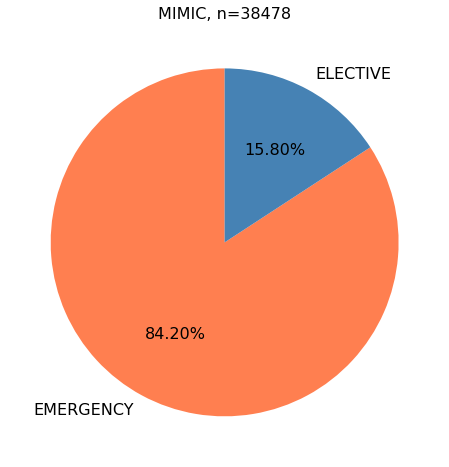

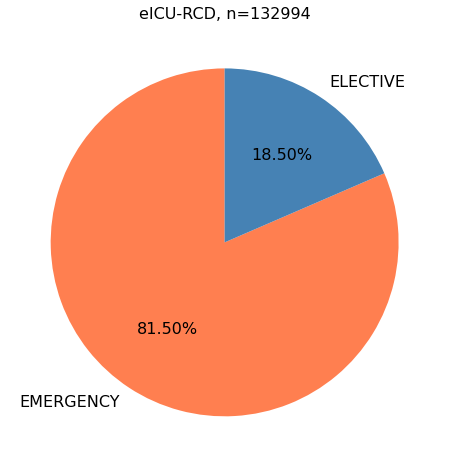

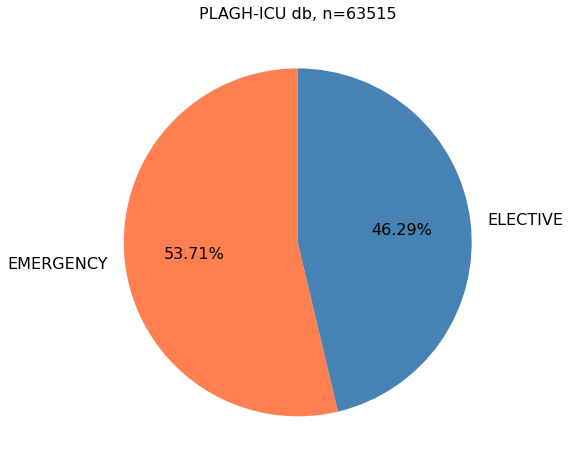

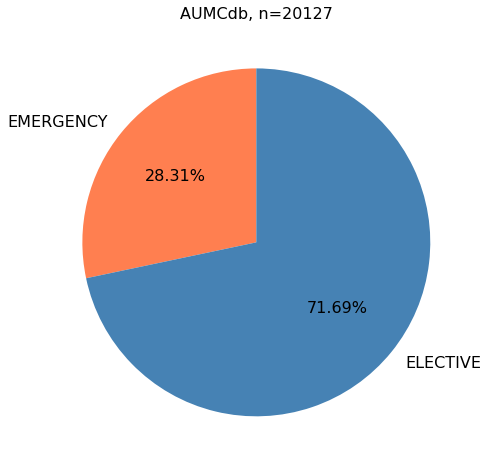

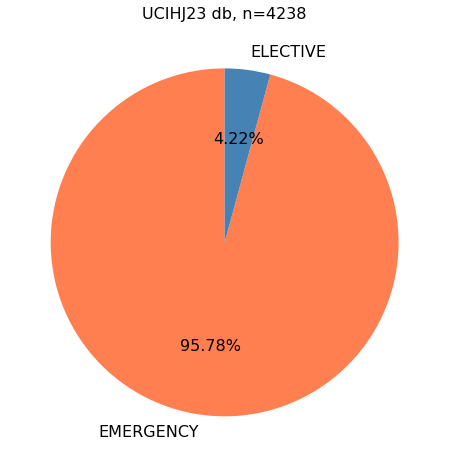

In [33]:
mpl.rcParams['font.size'] = 16
plt.figure(figsize=(8,8))
plt.pie(data_mimic['admission_type'].value_counts(),
       labels=['EMERGENCY','ELECTIVE'],
       colors=['coral','steelblue'],
       autopct = '%3.2f%%',
       startangle =90)
number=np.sum(data_mimic['admission_type'].notnull())
plt.ylabel('')
plt.title('MIMIC, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/mimic admission types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_eicu['admission_type'].value_counts(),
       labels=['EMERGENCY','ELECTIVE'],
       colors=['coral','steelblue'],
       autopct = '%3.2f%%',
       startangle =90)
number=np.sum(data_eicu['unittype'].notnull())
plt.ylabel('')
plt.title('eICU-RCD, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/eicu admission types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_plagh['admission_type'].value_counts(),
       labels=['EMERGENCY','ELECTIVE'],
       colors=['coral','steelblue'],
       autopct = '%3.2f%%',
       startangle =90)
number=np.sum(data_plagh['admission_type'].notnull())
plt.ylabel('')
plt.title('PLAGH-ICU db, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/plagh admission types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_aumc['admission_type'].value_counts().iloc[::-1],
       labels=['EMERGENCY','ELECTIVE'],
       colors=['coral','steelblue'],
       autopct = '%3.2f%%',
       startangle =90)
number=np.sum(data_aumc['admission_type'].notnull())
plt.ylabel('')
plt.title('AUMCdb, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/aumc admission types.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_HJ23['admission_type'].value_counts(),
       labels=['EMERGENCY','ELECTIVE'],
       colors=['coral','steelblue'],
       autopct = '%3.2f%%',
       startangle =90)
number=np.sum(data_HJ23['admission_type'].notnull())
plt.ylabel('')
plt.title('UCIHJ23 db, n={}'.format(number),fontsize=16)
plt.savefig('../figures/database description/hj23 admission types.png', dpi=300)

### Cardiac surgery patients

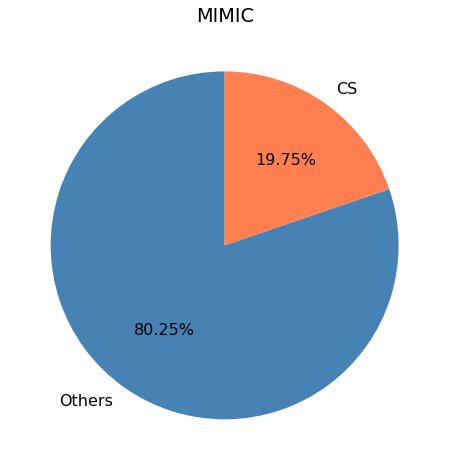

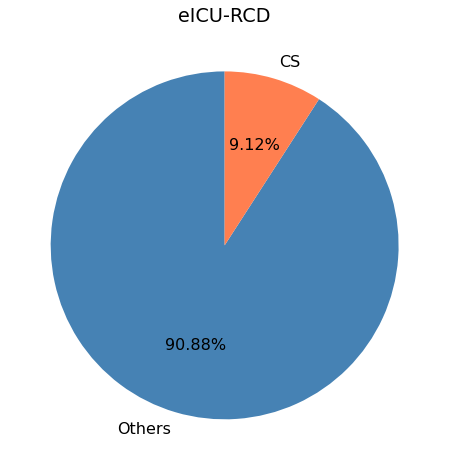

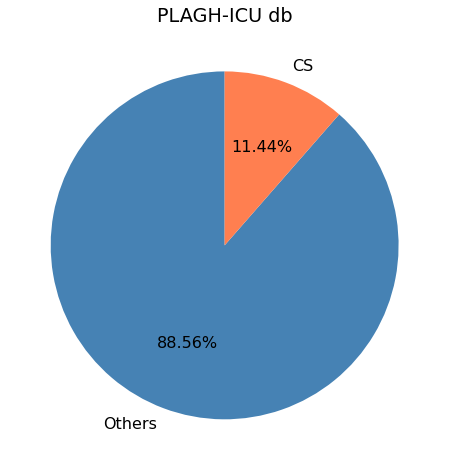

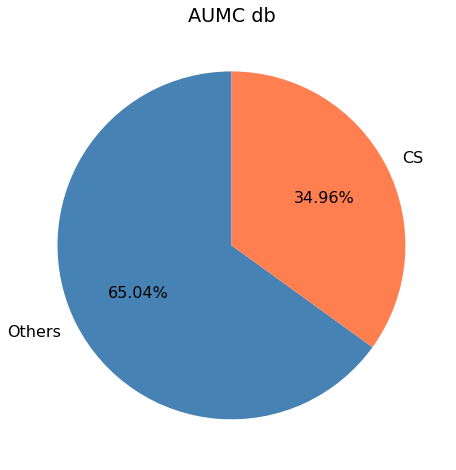

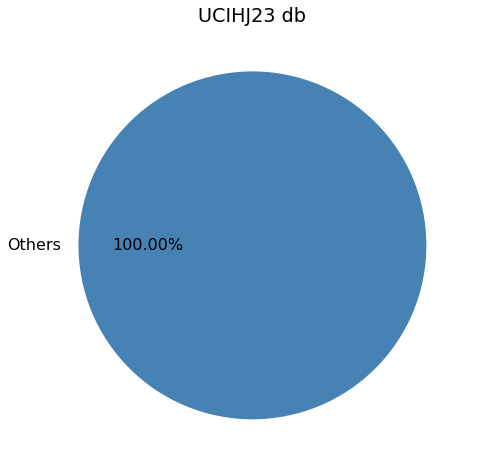

In [34]:
mpl.rcParams['font.size'] = 16
plt.figure(figsize=(8,8))
plt.pie(data_mimic['cardiac_surgery_flag'].value_counts(),
       labels=['Others','CS'],
       colors=['steelblue','coral'],
       autopct = '%3.2f%%',
       startangle =90)
plt.title('MIMIC')
plt.savefig('../figures/database description/mimic Cardiac surgery.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_eicu['cardiac_surgery_flag'].value_counts(),
       labels=['Others','CS'],
       colors=['steelblue','coral'],
       autopct = '%3.2f%%',
       startangle =90)
plt.title('eICU-RCD')
plt.savefig('../figures/database description/eicu Cardiac surgery.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_plagh['cardiac_surgery_flag'].value_counts(),
       labels=['Others','CS'],
       colors=['steelblue','coral'],
       autopct = '%3.2f%%',
       startangle =90)
plt.ylabel('')
plt.title('PLAGH-ICU db')
plt.savefig('../figures/database description/plagh Cardiac surgery.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_aumc['cardiac_surgery_flag'].value_counts(),
       labels=['Others','CS'],
       colors=['steelblue','coral'],
       autopct = '%3.2f%%',
       startangle =90)
plt.ylabel('')
plt.title('AUMC db')
plt.savefig('../figures/database description/aumc Cardiac surgery.png', dpi=300)

plt.figure(figsize=(8,8))
plt.pie(data_HJ23['cardiac_surgery_flag'].value_counts(),
       labels=['Others'],
       colors=['steelblue'],
       autopct = '%3.2f%%',
       startangle =0)
plt.ylabel('')
plt.title('UCIHJ23 db')
plt.savefig('../figures/database description/hj23 Cardiac surgery.png', dpi=300)

## dropped blew

### Violin Plot

In [22]:
vio_df=pd.DataFrame(columns=['age','icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag'])
df_1=data_mimic.loc[:,['age','icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag']]
df_1['database_flag']='MIMIC'
#print(df_1)
vio_df=vio_df.append(df_1)

df_2=data_eicu.loc[:,['age','icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag']]
df_2['database_flag']='e-ICU'
vio_df=vio_df.append(df_2)

df_3=data_plagh.loc[:,['age','icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag']]
df_3['database_flag']='PLAGH'
vio_df=vio_df.append(df_3)

df_4=data_aumc.loc[:,['icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag']]
df_4['database_flag']='AUMC'
vio_df=vio_df.append(df_4)

df_5=data_HJ23.loc[:,['age','icu_los_hours','hospital_los_hours','icu_expire_flag','database_flag']]
df_5['database_flag']='HJ23'
vio_df=vio_df.append(df_5)

vio_df.info()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['hospital_los_hours', 'database_flag'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
vio_df['icu_expire_flag']=vio_df['icu_expire_flag'].replace(1,'ICU Mortality')
vio_df['icu_expire_flag']=vio_df['icu_expire_flag'].replace(0,'Survival')

fig = plt.figure(figsize = (12,15))
sns.violinplot(x='age',y='database_flag',hue='icu_expire_flag',split=True,data = vio_df,palette = 'muted')
plt.legend(loc=2,fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlabel('Age',fontsize=16)
plt.savefig('../figures/database description/age distribution violin plot.png', dpi=300)

In [ ]:
vio_df.loc[vio_df['icu_los_hours']>600,'icu_los_hours']=np.nan
fig = plt.figure(figsize = (12,15))
sns.violinplot(x='icu_los_hours',y='database_flag',hue='icu_expire_flag',split=True,data = vio_df,palette = 'muted')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlabel('LOS in ICU (hours)',fontsize=16)
#plt.ylim(0,600)
plt.savefig('../figures/database description/LOS in ICU distribution violin plot.png', dpi=300)

In [ ]:
vio_df.loc[vio_df['hospital_los_hours']>1440,'hospital_los_hours']=np.nan
fig = plt.figure(figsize = (12,15))
sns.violinplot(x='hospital_los_hours',y='database_flag',hue='icu_expire_flag',split=True,data = vio_df,palette = 'muted')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('')
plt.xlabel('LOS in hospital (hours)',fontsize=16)
#plt.ylim(0,600)
plt.savefig('../figures/database description/LOS in hospital distribution violin plot.png', dpi=300)

## define functions

OVL is special, the lower and upper value integrate should be determined by the lab test

In [ ]:
def cohen_d(x, y):
    """
    Return SMD between two distributions
    """
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(
        ((nx - 1) * np.std(x, ddof=1)**2 +
         (ny - 1) * np.std(y, ddof=1)**2) / dof)

In [ ]:
#return a normal distribution with 'val1' and 'val2'quantile(2.5% and 95%)
def ResumeNorm(val1, val2):
    norm_dist = scipy.stats.norm
    norm_val1 = norm_dist.ppf(0.025)
    norm_val2 = norm_dist.ppf(0.975)
    a = (val1 - val2) / (norm_val1 - norm_val2)
    b = val1 - a * norm_val1
    return scipy.stats.norm(b, a)

In [ ]:
def get_OVL(dist1, dist2, lower, upper):
#     """
#         Overlapping coefficient: integration of min value of two distribution over R. 
#         To increase compute rate, use [0,1000] instead R
#     """
    func = lambda x: min(dist1.pdf(x), dist2.pdf(x))
    return integrate.quad(func, lower, upper)

In [ ]:
#comparation between databases, plot figure
def plot_betweendatabase(labname,group,lower,upper,bw):
    if group == 'all':
        df_mimic=data_mimic.copy()
        df_eicu=data_eicu.copy()
        df_plagh=data_plagh.copy()
        df_aumc=data_aumc.copy()
        df_HJ23=data_HJ23.copy()
        f_title=labname+' of all patients'
    elif group=='bestoutcome':
        df_mimic=data_mimic.loc[data_mimic['outcome_group']==1,:]
        df_eicu=data_eicu.loc[data_eicu['outcome_group']==1,:]
        df_plagh=data_plagh.loc[data_plagh['outcome_group']==1,:]
        df_aumc=data_aumc.loc[data_aumc['outcome_group']==1,:]
        df_HJ23=data_HJ23.loc[data_HJ23['outcome_group']==1,:]
        f_title=labname+' of best outcome patients'
    else:
        df_mimic=data_mimic.loc[data_mimic['icu_expire_flag']==group,:]
        df_eicu=data_eicu.loc[data_eicu['icu_expire_flag']==group,:]
        df_plagh=data_plagh.loc[data_plagh['icu_expire_flag']==group,:]
        df_aumc=data_aumc.loc[data_aumc['icu_expire_flag']==group,:]
        df_HJ23=data_HJ23.loc[data_HJ23['icu_expire_flag']==group,:]  
        if group == 0:
            f_title=labname+' of survival patients'
        else:
            f_title=labname+' of expired patients'   
            
    # count patients
    n_mimic = df_mimic[labname].dropna().count()
    n_eicu = df_eicu[labname].dropna().count()
    n_plagh = df_plagh[labname].dropna().count()
    n_aumc=df_aumc[labname].dropna().count()
    n_HJ23=df_HJ23[labname].dropna().count()
    print(f_title)
    print(n_mimic,n_eicu,n_plagh,n_aumc,n_HJ23)
    
    range_name=labname.split('_')[0].upper()
    
    ## Null hypothesis: are the mean of patient distribution same as normal value distribution? 
    # Sample normal range distribution first
    range_dist = ResumeNorm(lab_ranges[range_name][0], lab_ranges[range_name][1])
    norm_sample_mimic = range_dist.rvs(size=n_mimic, random_state=0)
    norm_sample_eicu = range_dist.rvs(size=n_eicu, random_state=0)
    norm_sample_aumc = range_dist.rvs(size=n_aumc, random_state=0)
    norm_sample_HJ23 = range_dist.rvs(size=n_HJ23, random_state=0)
    
    # SMD
    smd_mimic = '%.2f'%cohen_d(df_mimic[labname].dropna(), norm_sample_mimic)
    smd_eicu = '%.2f'%cohen_d(df_eicu[labname].dropna(), norm_sample_eicu)
    smd_aumc = '%.2f'%cohen_d(df_aumc[labname].dropna(), norm_sample_aumc)
    smd_HJ23 = '%.2f'%cohen_d(df_HJ23[labname].dropna(), norm_sample_HJ23)
    
    
    # Test case on pandas kde: gaussian kde 
    data_kde_mimic = gaussian_kde(df_mimic[labname].dropna())
    data_kde_eicu = gaussian_kde(df_eicu[labname].dropna())
    data_kde_aumc = gaussian_kde(df_aumc[labname].dropna())
    data_kde_HJ23 = gaussian_kde(df_HJ23[labname].dropna())
    
    
    #OVL
    ovl_mimic =  '%.2f'%max(get_OVL(data_kde_mimic, range_dist,lower,upper))
    ovl_eicu = '%.2f'%max(get_OVL(data_kde_eicu, range_dist,lower,upper))
    ovl_aumc = '%.2f'%max(get_OVL(data_kde_aumc, range_dist,lower,upper))
    ovl_HJ23 = '%.2f'%max(get_OVL(data_kde_HJ23, range_dist,lower,upper))
    
    
    if labname == 'lactate_max':
        ovl_plagh=np.nan
        smd_plagh=np.nan
    else:
        norm_sample_plagh = range_dist.rvs(size=n_plagh, random_state=0)
        smd_plagh ='%.2f'%cohen_d(df_HJ23[labname].dropna(), norm_sample_HJ23)
        data_kde_plagh = gaussian_kde(df_plagh[labname].dropna())
        ovl_plagh = '%.2f'%max(get_OVL(data_kde_plagh, range_dist,lower,upper))
    
    fig=plt.figure(figsize=(15,8))
    sns.kdeplot(df_mimic[labname].dropna(),color='r',bw=bw,
                label='MIMIC, OVL={}, SMD={}'.format(ovl_mimic,smd_mimic ))
    sns.kdeplot(df_eicu[labname].dropna(),color='b',bw=bw,
                label='e-ICU, OVL={}, SMD={}'.format(ovl_eicu,smd_eicu))
    sns.kdeplot(df_plagh[labname].dropna(),color='m',bw=bw,
                label='PLAGH, OVL={}, SMD={}'.format(ovl_plagh,smd_plagh))
    sns.kdeplot(df_aumc[labname].dropna(),color='c',bw=bw,
                label='AUMC, OVL={}, SMD={}'.format(ovl_aumc,smd_aumc))
    sns.kdeplot(df_HJ23[labname].dropna(),color='y',bw=bw,
                label='HJ23, OVL={}, SMD={}'.format(ovl_HJ23,smd_HJ23))
    
    plt.axvline(lab_ranges[range_name][0],color='k',linestyle='--', label='normal range')
    plt.axvline(lab_ranges[range_name][1],color='k',linestyle='--')
    
    plt.ylabel("Density", fontsize=16)
    plt.title(f_title,fontsize=22)
    plt.legend(fontsize=16)
    
    plt.savefig('../figures/comparation between databases/{}/{}.png'.format(labname,f_title), dpi=300)

In [ ]:
#best outcome vs ICU mortality in each database, plot figures
def polt_bestvsexpired(labname,database,bw):
    range_name=labname.split('_')[0].upper()
    
    if database.lower() == 'mimic':
        df_best=data_mimic.loc[data_mimic['outcome_group']==1,:]
        df_worst=data_mimic.loc[data_mimic['outcome_group']==5,:]
        q_1=data_mimic.loc[data_mimic['icu_expire_flag']==0,'icu_los_hours'].describe()['25%']
    if database.lower() == 'e-icu':
        df_best=data_eicu.loc[data_eicu['outcome_group']==1,:]
        df_worst=data_eicu.loc[data_eicu['outcome_group']==5,:]
        q_1=data_eicu.loc[data_eicu['icu_expire_flag']==0,'icu_los_hours'].describe()['25%']
    if database.lower() == 'plagh':
        df_best=data_plagh.loc[data_plagh['outcome_group']==1,:]
        df_worst=data_plagh.loc[data_plagh['outcome_group']==5,:]
        q_1=data_plagh.loc[data_plagh['icu_expire_flag']==0,'icu_los_hours'].describe()['25%']
    if database.lower() == 'aumc':
        df_best=data_aumc.loc[data_aumc['outcome_group']==1,:]
        df_worst=data_aumc.loc[data_aumc['outcome_group']==5,:]
        q_1=data_aumc.loc[data_aumc['icu_expire_flag']==0,'icu_los_hours'].describe()['25%']
    if database.lower() == 'hj23':
        df_best=data_HJ23.loc[data_HJ23['outcome_group']==1,:]
        df_worst=data_HJ23.loc[data_HJ23['outcome_group']==5,:]
        q_1=data_HJ23.loc[data_HJ23['icu_expire_flag']==0,'icu_los_hours'].describe()['25%']
        
    n_best=df_best[labname].dropna().count()
    n_worst=df_worst[labname].dropna().count()
    
    fig=plt.figure(figsize=(15,8))
    sns.kdeplot(df_best[labname].dropna(),color='r',bw=bw,
                label='Best outcome,LOS < {}(hours), n={}'.format('%.2f'%q_1,n_best ))
    sns.kdeplot(df_worst[labname].dropna(),color='b',bw=bw,
                label='Worst outcome, n={}'.format(n_worst))
    
    plt.axvline(lab_ranges[range_name][0],color='k',linestyle='--', label='normal range')
    plt.axvline(lab_ranges[range_name][1],color='k',linestyle='--')
    
    f_title=database+'_ '+ labname + ' on best outcome vs worst outcome'
    plt.ylabel("Density", fontsize=16)
    plt.title(f_title,fontsize=22)
    plt.legend(fontsize=16)
    
    plt.savefig('../figures/best vs worst/{}/{}.png'.format(labname,f_title), dpi=300)

In [ ]:
database_name=['MIMIC','e-ICU','PLAGH','AUMC','HJ23']
def plot_alldatabase(labname,bw):
    for name in database_name:
        polt_bestvsexpired(labname,name,bw)

## sodium_max

In [ ]:
plot_betweendatabase('sodium_max','all',100,180,0.8)
plt.xlim(120,160)
plot_betweendatabase('sodium_max','bestoutcome',100,180,0.8)
plt.xlim(120,160)
plot_betweendatabase('sodium_max',0,100,180,0.8)
plt.xlim(120,160)
plot_betweendatabase('sodium_max',1,100,180,1)
plt.xlim(120,180)

In [ ]:
plot_alldatabase('sodium_max',1)

## creatinine_max

In [ ]:
plot_betweendatabase('creatinine_max','all',0,np.inf,0.2)
plt.xlim(-2,8)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of all patients'), dpi=300)
plot_betweendatabase('creatinine_max','bestoutcome',0,np.inf,0.2)
plt.xlim(-2,8)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of best outcome patients'), dpi=300)
plot_betweendatabase('creatinine_max',0,-3,np.inf,0.2)
plt.xlim(-2,8)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of survival patients'), dpi=300)
plot_betweendatabase('creatinine_max',1,-3,np.inf,0.2)
plt.xlim(-2,8)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('creatinine_max','creatinine_max of expired patients'), dpi=300)

In [ ]:
plot_alldatabase('creatinine_max',0.3)

## hemoglobin_min

In [ ]:
plot_betweendatabase('hemoglobin_min','all',2.5,np.inf,0.6)
plt.xlim(2.5,20)
plot_betweendatabase('hemoglobin_min','bestoutcome',2.5,np.inf,0.6)
plt.xlim(2.5,20)
plot_betweendatabase('hemoglobin_min',0,2.5,np.inf,0.6)
plt.xlim(2.5,20)
plot_betweendatabase('hemoglobin_min',1,2.5,np.inf,0.6)
plt.xlim(2.5,20)

In [ ]:
plot_alldatabase('hemoglobin_min',0.6)

## lactate_max

In [ ]:
plot_betweendatabase('lactate_max','all',0,np.inf,0.2)
plt.xlim(-2,15)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of all patients'), dpi=300)
plot_betweendatabase('lactate_max','bestoutcome',0,np.inf,0.2)
plt.xlim(-2,15)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of best outcome patients'), dpi=300)
plot_betweendatabase('lactate_max',0,0,np.inf,0.2)
plt.xlim(-2,15)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of survival patients'), dpi=300)
plot_betweendatabase('lactate_max',1,0,np.inf,0.2)
plt.xlim(-2,15)
plt.savefig('../figures/comparation between databases/{}/{}.png'.format('lactate_max','lactate_max of expired patients'), dpi=300)

In [ ]:
plot_alldatabase('lactate_max',0.3)

## bicarbonate_min

In [ ]:
plot_betweendatabase('bicarbonate_min','all',0,np.inf,0.8)
plt.xlim(0,40)
plot_betweendatabase('bicarbonate_min','bestoutcome',0,np.inf,0.8)
plt.xlim(0,40)
plot_betweendatabase('bicarbonate_min',0,0,np.inf,0.8)
plt.xlim(0,40)
plot_betweendatabase('bicarbonate_min',1,0,np.inf,1)
plt.xlim(0,40)

In [ ]:
plot_alldatabase('bicarbonate_min',0.7)

## boxplot, best vs worst

In [ ]:
lab_test_df=pd.DataFrame()
temp_df=data_mimic.loc[(data_mimic['outcome_group']==1) | (data_mimic['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='MIMIC'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_eicu.loc[(data_eicu['outcome_group']==1) | (data_eicu['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='e-ICU'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_plagh.loc[(data_plagh['outcome_group']==1) | (data_plagh['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='PLAGH'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_aumc.loc[(data_aumc['outcome_group']==1) | (data_aumc['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='AUMC'
lab_test_df=lab_test_df.append(temp_df)
temp_df=data_HJ23.loc[(data_HJ23['outcome_group']==1) | (data_HJ23['outcome_group']==5),['sodium_max','creatinine_max','lactate_max','hemoglobin_min','bicarbonate_min','outcome_group']]
temp_df['database_label']='HJ23'
lab_test_df=lab_test_df.append(temp_df)
lab_test_df.reset_index(drop=True,inplace=True)

In [ ]:
lab_test_df['outcome_group'].replace(1,'Best outcome, LOS < 1st quantile', inplace=True)
lab_test_df['outcome_group'].replace(5,'Worst outcome, expired patients', inplace=True)
lab_test_df.sort_values(by=['outcome_group'],inplace=True)

### sodium_max

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[133, 133],'r--',linewidth=2)
plt.plot([-0.5,4.5],[145, 145],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[133], [145],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.boxplot(x="database_label", y="sodium_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
#sns.violinplot(x='database_label',y='sodium_max',hue='outcome_group',order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],split=True,data = lab_test_df,palette = 'muted')
plt.xlabel('Maximum of Sodium',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(115,200)
plt.savefig('../figures/best vs worst/sodium_max_box_plot.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[133, 133],'r--',linewidth=2)
plt.plot([-0.5,4.5],[145, 145],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[133], [145],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

#sns.boxplot(x="database_label", y="sodium_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
sns.violinplot(x='database_label',
               y='sodium_max',
               hue='outcome_group',
               order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],
               split=True,
               data = lab_test_df,
               palette = 'muted',
               #scale="count",
               inner="quartile")
plt.xlabel('Maximum of Sodium',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(bbox_to_anchor=(0.7, 1.15), fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(115,200)
plt.savefig('../figures/best vs worst/sodium_max_vio_plot.png', dpi=300)

### creatinine_max

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[0.4, 0.4],'r--',linewidth=2)
plt.plot([-0.5,4.5],[1.1, 1.1],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[0.4], [1.1],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.boxplot(x="database_label", y="creatinine_max", hue="outcome_group", order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Maximum of Creatinine',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,25)
plt.savefig('../figures/best vs worst/creatinine_max_box_plot.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[0.4, 0.4],'r--',linewidth=2)
plt.plot([-0.5,4.5],[1.1, 1.1],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[0.4], [1.1],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

#sns.boxplot(x="database_label", y="sodium_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
sns.violinplot(x='database_label',
               y='creatinine_max',
               hue='outcome_group',
               order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],
               split=True,
               data = lab_test_df,
               palette = 'muted',
               #scale="count",
               bw=.2,
               inner="quartile")
plt.xlabel('Maximum of Creatinine',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(bbox_to_anchor=(0.7, 1.15), fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,15)
plt.savefig('../figures/best vs worst/creatinine_max_vio_plot.png', dpi=300)

### lactate_max

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[0.5, 0.5],'r--',linewidth=2)
plt.plot([-0.5,4.5],[2, 2],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[0.5], [2],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.boxplot(x="database_label", y="lactate_max", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Maximum of Lactate',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,35)
plt.savefig('../figures/best vs worst/lactate_max_box_plot.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[0.5, 0.5],'r--',linewidth=2)
plt.plot([-0.5,4.5],[2, 2],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[0.5], [2],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.violinplot(x='database_label',
               y='lactate_max',
               hue='outcome_group',
               order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],
               split=True,
               data = lab_test_df,
               palette = 'muted',
               #scale="count",
               bw=.2,
               inner="quartile")
plt.xlabel('Maximum of Lactate',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(bbox_to_anchor=(0.7, 1.15), fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,20)
plt.savefig('../figures/best vs worst/lactate_max_vio_plot.png', dpi=300)

### hemoglobin_min

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[11.2, 11.2],'r--',linewidth=2)
plt.plot([-0.5,4.5],[15.7, 15.7],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[11.2], [15.7],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.boxplot(x="database_label", y="hemoglobin_min", hue="outcome_group",order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],  data=lab_test_df)
plt.xlabel('Minimum of Hemoglobin',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,25)
plt.savefig('../figures/best vs worst/hemoglobin_min_box_plot.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
#plot the normal range
plt.plot([-0.5,4.5],[11.2, 11.2],'r--',linewidth=2)
plt.plot([-0.5,4.5],[15.7, 15.7],'r--',linewidth=2)
plt.fill_between([-0.5,4.5],[11.2], [15.7],facecolor='green',alpha=0.1)
#plt.text(4.5,(133 + 145)/2,'Normal Range',fontsize=16,rotation=90)

sns.violinplot(x='database_label',
               y='hemoglobin_min',
               hue='outcome_group',
               order=['MIMIC','e-ICU','PLAGH','AUMC','HJ23'],
               split=True,
               data = lab_test_df,
               palette = 'muted',
               #scale="count",
               bw=.2,
               inner="quartile")
plt.xlabel('Minimum of Hemoglobin',fontsize=16)
plt.xticks(fontsize=16)
plt.legend(bbox_to_anchor=(0.7, 1.15), fontsize=16)
plt.ylabel('')
plt.yticks(fontsize=16)
plt.ylim(0,25)
plt.savefig('../figures/best vs worst/hemoglobin_min_vio_plot.png', dpi=300)

## compare lab results in different ICU types in PLAGH

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[data_plagh['unittype']==icu,:]['hemoglobin_min'].notnull())
    if n > 4000:
        sns.kdeplot(data_plagh.loc[data_plagh['unittype']==icu,:]['hemoglobin_min'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of different ICU in PLAGH database (n > 4000)',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/PLAGH ICU/hemoglobin_min_over4000_all.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[(data_plagh['unittype']==icu) & (data_plagh['icu_expire_flag']==1),:]['hemoglobin_min'].notnull())
    if n > 400:
        sns.kdeplot(data_plagh.loc[(data_plagh['unittype']==icu) & (data_plagh['icu_expire_flag']==1),:]['hemoglobin_min'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of different ICU in PLAGH database (n > 400 & expired)',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/PLAGH ICU/hemoglobin_min_over400_expired.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[data_plagh['unittype']==icu,:]['hemoglobin_min'].notnull())
    if n <= 4000:
        sns.kdeplot(data_plagh.loc[data_plagh['unittype']==icu,:]['hemoglobin_min'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of different ICU in PLAGH database (n <= 4000)',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/PLAGH ICU/hemoglobin_min_less4000_all.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[data_plagh['unittype']==icu,:]['creatinine_max'].notnull())
    if n > 4000:
        sns.kdeplot(data_plagh.loc[data_plagh['unittype']==icu,:]['creatinine_max'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(0.4,color='k',linestyle='--', label='normal range')
plt.axvline(1.1,color='k',linestyle='--')
plt.title('Maxumum Creatinine distribution of different ICU in PLAGH database (n > 4000)',fontsize=18)
plt.ylabel("Density", fontsize=16) 
plt.legend(fontsize=16)
plt.xlim(-2,10)
plt.savefig('../figures/PLAGH ICU/creatinine_max_over4000_all.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[(data_plagh['unittype']==icu) & (data_plagh['icu_expire_flag']==1),:]['creatinine_max'].notnull())
    if n > 400:
        sns.kdeplot(data_plagh.loc[(data_plagh['unittype']==icu) & (data_plagh['icu_expire_flag']==1),:]['creatinine_max'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(0.4,color='k',linestyle='--', label='normal range')
plt.axvline(1.1,color='k',linestyle='--')
plt.title('Maxumum Creatinine distribution of different ICU in PLAGH database (n > 400 & expired)',fontsize=18)
plt.ylabel("Density", fontsize=16) 
plt.legend(fontsize=16)
plt.xlim(-2,10)
plt.savefig('../figures/PLAGH ICU/creatinine_max_over400_expired.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_plagh['unittype'].unique():
    n=np.sum(data_plagh.loc[data_plagh['unittype']==icu,:]['creatinine_max'].notnull())
    if n <= 4000:
        sns.kdeplot(data_plagh.loc[data_plagh['unittype']==icu,:]['creatinine_max'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(0.4,color='k',linestyle='--', label='normal range')
plt.axvline(1.1,color='k',linestyle='--')
plt.title('Maxumum Creatinine distribution of different ICU in PLAGH database (n <= 4000)',fontsize=18)
plt.ylabel("Density", fontsize=16) 
plt.legend(fontsize=16)
plt.xlim(-2,10)

## compare lab results in different ICU types in MIMIC

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_mimic['unittype'].unique():
    n=np.sum(data_mimic.loc[data_mimic['unittype']==icu,:]['hemoglobin_min'].notnull())
    if n > 0:
        sns.kdeplot(data_mimic.loc[data_mimic['unittype']==icu,:]['hemoglobin_min'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of different ICU in MIMIC database ',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/MIMIC_eICU ICUs/MIMIC_hemoglobin_min.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_mimic['unittype'].unique():
    n=np.sum(data_mimic.loc[data_mimic['unittype']==icu,:]['creatinine_max'].notnull())
    if n > 0:
        sns.kdeplot(data_mimic.loc[data_mimic['unittype']==icu,:]['creatinine_max'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(0.4,color='k',linestyle='--', label='normal range')
plt.axvline(1.1,color='k',linestyle='--')
plt.title('Maxumum Creatinine distribution of different ICU in MIMIC database',fontsize=18)
plt.ylabel("Density", fontsize=16) 
plt.legend(fontsize=16)
plt.xlim(-2,10)
plt.savefig('../figures/MIMIC_eICU ICUs/MIMIC_creatinine_max.png', dpi=300)

## compare lab results in different ICU types in e-ICU

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_eicu['unittype'].unique():
    n=np.sum(data_eicu.loc[data_eicu['unittype']==icu,:]['hemoglobin_min'].notnull())
    if n > 0:
        sns.kdeplot(data_eicu.loc[data_eicu['unittype']==icu,:]['hemoglobin_min'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of different ICU in e-ICU database ',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/MIMIC_eICU ICUs/eICU_hemoglobin_min.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
for icu in data_eicu['unittype'].unique():
    n=np.sum(data_eicu.loc[data_eicu['unittype']==icu,:]['creatinine_max'].notnull())
    if n > 0:
        sns.kdeplot(data_eicu.loc[data_eicu['unittype']==icu,:]['creatinine_max'].dropna(),label='{}: n={}'.format(icu,n))
plt.axvline(0.4,color='k',linestyle='--', label='normal range')
plt.axvline(1.1,color='k',linestyle='--')
plt.title('Maxumum Creatinine distribution of different ICU in e-ICU database',fontsize=18)
plt.ylabel("Density", fontsize=16) 
plt.legend(fontsize=16)
plt.xlim(-2,10)
plt.savefig('../figures/MIMIC_eICU ICUs/eICU_creatinine_max.png', dpi=300)

## compare the same ICU in different databases

### CCU - hemoglobin

In [ ]:
fig = plt.figure(figsize = (15,8))
#MIMIC
n=np.sum(data_mimic.loc[data_mimic['unittype']=='CCU',:]['hemoglobin_min'].notnull())
sns.kdeplot(data_mimic.loc[data_mimic['unittype']=='CCU',:]['hemoglobin_min'].dropna(),label='MIMIC: CCU: n={}'.format(n))
#e-ICU
n=np.sum(data_eicu.loc[data_eicu['unittype']=='Cardiac ICU',:]['hemoglobin_min'].notnull())
sns.kdeplot(data_eicu.loc[data_eicu['unittype']=='Cardiac ICU',:]['hemoglobin_min'].dropna(),label='e-ICU: CCU: n={}'.format(n))
#PLAGH
n=np.sum(data_plagh.loc[data_plagh['unittype']=='CCU',:]['hemoglobin_min'].notnull())
sns.kdeplot(data_plagh.loc[data_plagh['unittype']=='CCU',:]['hemoglobin_min'].dropna(),label='PLAGH: CCU: n={}'.format(n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of Cardiac ICU (all)',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/comparation between databases/CCU/hemoglobin_all.png', dpi=300)

In [ ]:
fig = plt.figure(figsize = (15,8))
#MIMIC
n=np.sum(data_mimic.loc[(data_mimic['unittype']=='CCU') & (data_mimic['icu_expire_flag']==1),:]['hemoglobin_min'].notnull())
sns.kdeplot(data_mimic.loc[(data_mimic['unittype']=='CCU') & (data_mimic['icu_expire_flag']==1),:]['hemoglobin_min'].dropna(),label='MIMIC: CCU: n={}'.format(n))
#e-ICU
n=np.sum(data_eicu.loc[(data_eicu['unittype']=='Cardiac ICU') & (data_eicu['icu_expire_flag']==1),:]['hemoglobin_min'].notnull())
sns.kdeplot(data_eicu.loc[(data_eicu['unittype']=='Cardiac ICU') & (data_eicu['icu_expire_flag']==1),:]['hemoglobin_min'].dropna(),label='e-ICU: CCU: n={}'.format(n))
#PLAGH
n=np.sum(data_plagh.loc[(data_plagh['unittype']=='CCU') & (data_plagh['icu_expire_flag']==1),:]['hemoglobin_min'].notnull())
sns.kdeplot(data_plagh.loc[(data_plagh['unittype']=='CCU') & (data_plagh['icu_expire_flag']==1),:]['hemoglobin_min'].dropna(),label='PLAGH: CCU: n={}'.format(n))
plt.axvline(11.2,color='k',linestyle='--', label='normal range')
plt.axvline(15.7,color='k',linestyle='--')
plt.title('Minumum Hemoglobin distribution of Cardiac ICU (expired)',fontsize=18)
plt.ylabel("Density", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('../figures/comparation between databases/CCU/hemoglobin_expired.png', dpi=300)